In [141]:
import matplotlib.pyplot as plt
import numpy as np
import ujipenchars2
from drawing import Drawing
from preprocessing import DrawingScaler, resample_drawing
from dtw import dtw, dtw_distance_matrix
from sklearn.neighbors import KNeighborsClassifier

In [100]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)

drawing_scaler = DrawingScaler()
train = drawing_scaler.fit_transform(train)
test = drawing_scaler.transform(test)

data = train + test
resampled_data = [resample_drawing(drawing, 50) for drawing in data]
D = dtw_distance_matrix(np.array([np.vstack(drawing.strokes) for drawing in resampled_data], dtype=np.float32))
labels = np.array([int(drawing.label) for drawing in data], dtype=np.int8)

In [163]:
def plot_drawings(drawings: list[Drawing], ncols=2,):
    n = len(drawings)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, sharex=True)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            drawing = drawings[k]
            plt.title(drawing.label)
            for stroke in drawing.strokes:
                axes[i, j].plot(stroke[:,0], stroke[:,1], color='black', linewidth=1, solid_capstyle='round')
            plt.axis('scaled')
            k += 1

In [102]:
np.fill_diagonal(D, 2*np.max(D))
def findK(D, train, labels):
    n = len(train)
    maxScore = 0
    bestK = 0
    for k in range(1, n):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute', metric='precomputed')
        knn.fit(D[:n, :n], labels[:n]) #train data, train data
        score = knn.score(D[:n, :n], labels[:n])*100 #test data, train data
        print(score)
        if score > maxScore:
            maxScore = score
            bestK = k
    return bestK

bestK = findK(D, train, labels)

99.625
99.625
99.25
99.125
98.625
98.875
98.75
98.75
98.75
98.75
98.375
98.375
98.25
98.25
98.125
98.0
97.875
97.625
97.625
97.625
97.375
97.375
97.375
97.5
97.375
97.375
97.375
97.375
97.375
97.375
97.375
97.25
97.25
97.25
97.25
97.25
97.25
97.125
97.25
97.25
97.125
97.0
97.125
96.875
96.75
96.75
96.75
96.75
96.75
96.625
96.625
96.75
96.625
96.75
96.625
96.75
96.625
96.625
96.75
96.625
96.5
96.375
96.25
96.125
96.25
96.375
96.375
96.375
96.25
96.25
96.25
96.375
96.25
96.125
96.25
96.125
96.25
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
95.875
95.875
95.75
95.75
95.75
95.75
95.625
95.75
95.75
95.75
95.75
95.875
95.875
95.75
95.5
95.5
95.5
95.5
95.625
95.5
95.625
95.625
95.5
95.5
95.5
95.5
95.375
95.25
95.25
95.25
95.25
95.25
95.25
95.25
95.25
95.125
95.125
95.0
95.0
95.0
95.0
95.125
95.125
95.0
95.0
94.875
94.875
94.75
94.75
94.75
94.75
94.75
94.875
94.75
94.75
94.75
94.75
94.625
94.625
94.5
94.5
94.5
94.5
94.5
94.5
94.5
94.625
94.625
94.75
94.75
94.625
94.625
94.625
94

In [160]:
def knn(D, train, test, labels, k=bestK):
    n = len(train)
    m = len(test)
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute', metric='precomputed')
    knn.fit(D[:n, :n], labels[:n]) #train data, train data
    predict = knn.predict(D[n:, :n]) #test data, train data
    wrong_indices = []
    for i in range(m):
        if predict[i] != labels[i]:
            wrong_indices.append(i)
    score = knn.score(D[n:, :n], labels[n:])*100 #test data, train data
    return wrong_indices, score

k =  1 , score =  98.0
[20, 21, 36, 37, 239, 273, 318, 348]


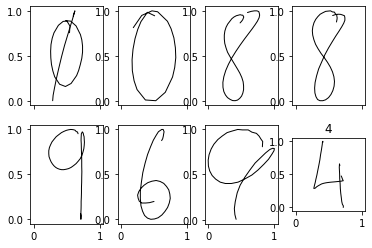

In [164]:
k = bestK
wrong_indices, score = knn(D, train, test, labels, k)
print("k = ", k, ", score = ", score)
print(wrong_indices)
wrong_drawings = [train[i] for i in wrong_indices]
plot_drawings(wrong_drawings, ncols=4)